In [49]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

import shapely.wkt
from shapely.geometry import mapping
import ast

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [50]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
results = pd.read_csv("/content/drive/MyDrive/covid_election_data/nyc_elections.csv")
results.set_index(["Unit Name", "AD", "ED"], inplace=True)

In [53]:
results.head()

,,,Tally
Unit Name,AD,ED,
Public Counter,65,1,393
Manually Counted Emergency,65,1,0
Absentee / Military,65,1,263
Federal,65,1,7
Special Presidential,65,1,0


In [54]:
candidates = [
  'Joseph R. Biden / Kamala D. Harris (Democratic)',
  'Joseph R. Biden / Kamala D. Harris (Working Families)',
  'Donald J. Trump / Michael R. Pence (Republican)',
  'Donald J. Trump / Michael R. Pence (Conservative)',
  'Howie Hawkins / Angela Nicole Walker (Green)',
  'Jo Jorgensen / Jeremy Cohen (Libertarian)',
  'Brock Pierce / Karla Ballard (Independence)',
]

In [55]:
biden_names = [candidates[0], candidates[1]]
trump_names = [candidates[2], candidates[3]]

In [56]:
biden_results = sum(map(lambda name: results.loc[name], biden_names))
trump_results = sum(map(lambda name: results.loc[name], trump_names))
totals = sum(map(lambda name: results.loc[name], candidates)) + results.loc["Scattered"].reindex(trump_results.index).fillna(0)

In [57]:
biden_percentage = (biden_results / totals).fillna(0)
trump_percentage = (trump_results / totals).fillna(0)
biden_margin = biden_percentage - trump_percentage

In [58]:
modzcta = pd.read_csv("/content/drive/MyDrive/covid_election_data/Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv")

In [59]:
modzcta_polygons = {}
for code, shape in zip(modzcta["MODZCTA"], modzcta["the_geom"]):
  modzcta_polygons[code] = shapely.wkt.loads(shape)

In [60]:
nyed = pd.read_csv("/content/drive/MyDrive/covid_election_data/nyed.csv")

In [61]:
nyed_polygons = {}
for code, shape in zip(nyed["ElectDist"], nyed["the_geom"]):
  nyed_polygons[str(code)] = shapely.wkt.loads(shape)

In [62]:
from collections import defaultdict

zipcode_eds = defaultdict(lambda: [])

for (ed, ed_shape) in nyed_polygons.items():
  for (code, zip_shape) in modzcta_polygons.items():
    if zip_shape.contains(ed_shape.centroid):
      zipcode_eds[code].append(ed)

In [63]:
biden_margin_for_zipcode = {}
for (code, edcodes) in zipcode_eds.items():
  tot = 0
  biden_votes = 0
  trump_votes = 0
  for edcode in edcodes:
    ad = int(edcode[:2])
    ed = int(edcode[2:])
    if (ad, ed) in totals.index:
      tot += totals.loc[(ad, ed)]["Tally"]
      biden_votes += biden_results.loc[(ad, ed)]["Tally"]
      trump_votes += trump_results.loc[(ad, ed)]["Tally"]

  biden_p = biden_votes / tot if tot > 0 else 0
  trump_p = trump_votes / tot if tot > 0 else 0
  biden_margin_for_zipcode[code] = biden_p - trump_p

In [64]:
covid_latest = pd.read_csv("/content/drive/MyDrive/covid_election_data/last7days-by-modzcta.csv")

In [65]:
covid_latest.set_index(["modzcta"], inplace=True)

In [66]:
biden_margins = pd.DataFrame.from_dict(biden_margin_for_zipcode, orient="index").sort_index()
biden_margins.columns = ["biden_margin"]

In [101]:
covid_vs_elections = pd.concat([covid_latest, biden_margins], axis=1).dropna()

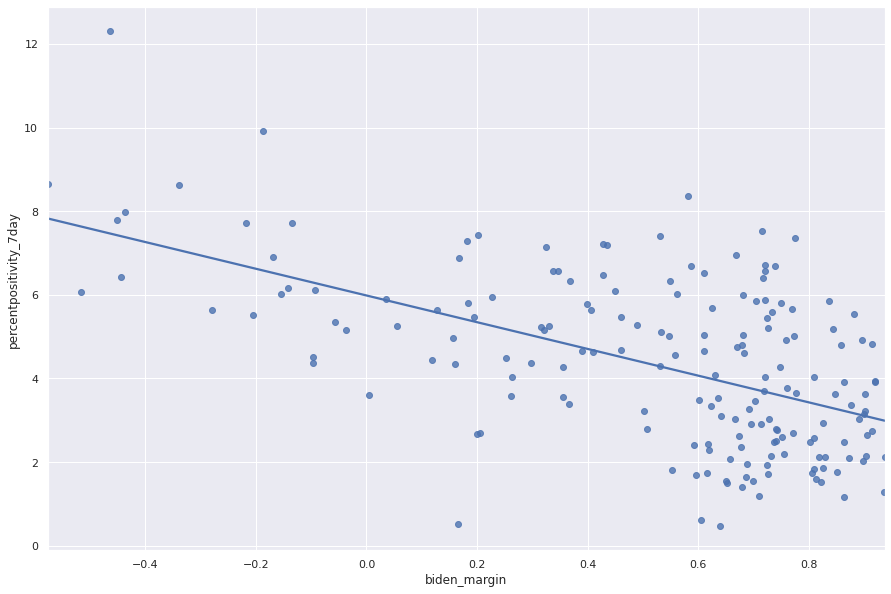

In [102]:
sns.set(rc={'figure.figsize':(15,10)})
sns.regplot(x='biden_margin', y='percentpositivity_7day', data=covid_vs_elections, ci=None, robust=True)

In [1]:
pip install CensusData

     |████████████████████████████████| 24.9MB 1.6MB/s 
  Created wheel for CensusData: filename=CensusData-1.10-cp36-none-any.whl size=26468242 sha256=4bab27ad0314777a559ae5b54c8773a4deea746220dfcf40391475732a797837
  Stored in directory: /root/.cache/pip/wheels/f3/50/8a/4a919497c7c3ff4c6a8884d665e930278af38ceff600225de7
Successfully built CensusData


In [2]:
import censusdata

In [97]:
censusdata.censustable("acs5", 2018, "B02001")

OrderedDict([('B02001_001E',
              {'concept': 'RACE',
               'label': 'Estimate!!Total',
               'predicateType': 'int'}),
             ('B02001_002E',
              {'concept': 'RACE',
               'label': 'Estimate!!Total!!White alone',
               'predicateType': 'int'}),
             ('B02001_003E',
              {'concept': 'RACE',
               'label': 'Estimate!!Total!!Black or African American alone',
               'predicateType': 'int'}),
             ('B02001_004E',
              {'concept': 'RACE',
               'label': 'Estimate!!Total!!American Indian and Alaska Native alone',
               'predicateType': 'int'}),
             ('B02001_005E',
              {'concept': 'RACE',
               'label': 'Estimate!!Total!!Asian alone',
               'predicateType': 'int'}),
             ('B02001_006E',
              {'concept': 'RACE',
               'label': 'Estimate!!Total!!Native Hawaiian and Other Pacific Islander alone',
         

In [100]:
import censusdata
population = censusdata.download('acs5', 2018,
                             censusdata.censusgeo([('zip code tabulation area', '*')]),
                             ['B01003_001E', # total pop
                              'B15003_001E', 'B15003_021E', 'B15003_022E', 'B15003_023E', 'B15003_024E', 'B15003_025E', # education
                              'B19013_001E', # income
                              'B01002_001E', # median age
                              'B11016_001E', # total households
                              'B02001_002E', # race, white
                              ])

pop = population.reset_index()
pop["modzcta"] = pop["index"].map(lambda geo: geo.params()[0][1]).astype(int)
pop["population"] = pop["B01003_001E"]
pop["median_income"] = pop["B19013_001E"]
pop["median_age"] = pop["B01002_001E"]
pop["percent_over_25_without_college_degree"] = 1 - (pop["B15003_021E"] + pop['B15003_022E'] + pop['B15003_023E'] + pop['B15003_024E'] + pop['B15003_025E']) / pop['B15003_001E']
pop["total_households"] = pop["B11016_001E"]
pop["avg_num_people_per_household"] = pop["population"] / pop["total_households"]
pop["percent_white"] = pop["B02001_002E"] / pop["population"]
pop = pop[["modzcta", "population", "median_income", "median_age", "percent_over_25_without_college_degree", "avg_num_people_per_household", "percent_white"]]
pop = pop.set_index("modzcta")

In [103]:
covid_vs_elections = covid_vs_elections.join(pop)

In [104]:
# removing Breezy Point outlier with very high case rate and small population
covid_vs_elections.drop(11697, inplace=True)

In [106]:
lm_no_margin = sm.OLS.from_formula("percentpositivity_7day ~ median_income + median_age + percent_over_25_without_college_degree + avg_num_people_per_household + percent_white", covid_vs_elections).fit()
lm_no_margin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     percentpositivity_7day   R-squared:                       0.618
Model:                                OLS   Adj. R-squared:                  0.606
Method:                     Least Squares   F-statistic:                     54.91
Date:                    Sun, 06 Dec 2020   Prob (F-statistic):           9.70e-34
Time:                            18:27:50   Log-Likelihood:                -283.11
No. Observations:                     176   AIC:                             578.2
Df Residuals:                         170   BIC:                             597.2
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -5.1610      1.119     -4.614      0.000      -7.369      -2.953
median_income                          -7.192e-06   5.56e-06     -1.295      0.197   -1.82e-05    3.77e-06
median_age                                 0.0313      0.021      1.466      0.145      -0.011       0.073
percent_over_25_without_college_degree     5.3724      1.447      3.712      0.000       2.515       8.229
avg_num_people_per_household               1.6311      0.347      4.703      0.000       0.946       2.316
percent_white                              3.4629      0.516      6.710      0.000       2.444       4.482
==============================================================================
Omnibus:                        1.525   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.466   Jarque-Bera (JB):                1.220
Skew:                           0.194   Prob(JB):                        0.543
Kurtosis:                       3.128   Cond. No.                     1.37e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [136]:
lm_edu = sm.OLS.from_formula("percentpositivity_7day ~ percent_over_25_without_college_degree", covid_vs_elections).fit()
lm_edu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     percentpositivity_7day   R-squared:                       0.449
Model:                                OLS   Adj. R-squared:                  0.446
Method:                     Least Squares   F-statistic:                     141.7
Date:                    Sun, 06 Dec 2020   Prob (F-statistic):           2.77e-24
Time:                            18:34:17   Log-Likelihood:                -315.27
No. Observations:                     176   AIC:                             634.5
Df Residuals:                         174   BIC:                             640.9
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.8881      0.309      2.871      0.005       0.278       1.499
percent_over_25_without_college_degree     6.4814      0.544     11.904      0.000       5.407       7.556
==============================================================================
Omnibus:                        7.949   Durbin-Watson:                   1.436
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.989
Skew:                           0.425   Prob(JB):                       0.0184
Kurtosis:                       3.605   Cond. No.                         6.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

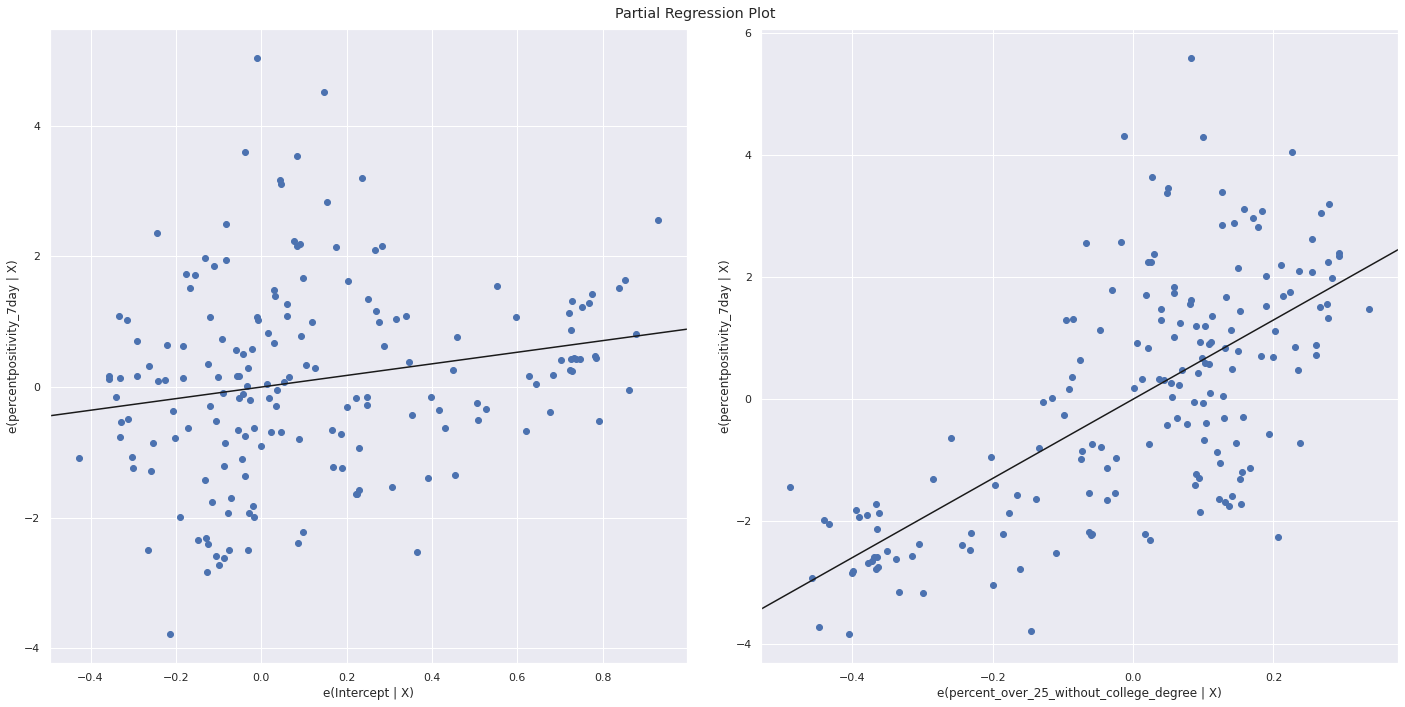

In [137]:
fig = sm.graphics.plot_partregress_grid(lm_edu)
fig.set_size_inches(20, 10)

In [138]:
lm_edu_race = sm.OLS.from_formula("percentpositivity_7day ~ percent_over_25_without_college_degree + percent_white", covid_vs_elections).fit()
lm_edu_race.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     percentpositivity_7day   R-squared:                       0.558
Model:                                OLS   Adj. R-squared:                  0.553
Method:                     Least Squares   F-statistic:                     109.3
Date:                    Sun, 06 Dec 2020   Prob (F-statistic):           2.04e-31
Time:                            18:35:43   Log-Likelihood:                -295.81
No. Observations:                     176   AIC:                             597.6
Df Residuals:                         173   BIC:                             607.1
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -2.3686      0.570     -4.156      0.000      -3.493      -1.244
percent_over_25_without_college_degree     9.5722      0.680     14.083      0.000       8.231      10.914
percent_white                              3.5160      0.537      6.545      0.000       2.456       4.576
==============================================================================
Omnibus:                        1.639   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.441   Jarque-Bera (JB):                1.239
Skew:                           0.151   Prob(JB):                        0.538
Kurtosis:                       3.278   Cond. No.                         12.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

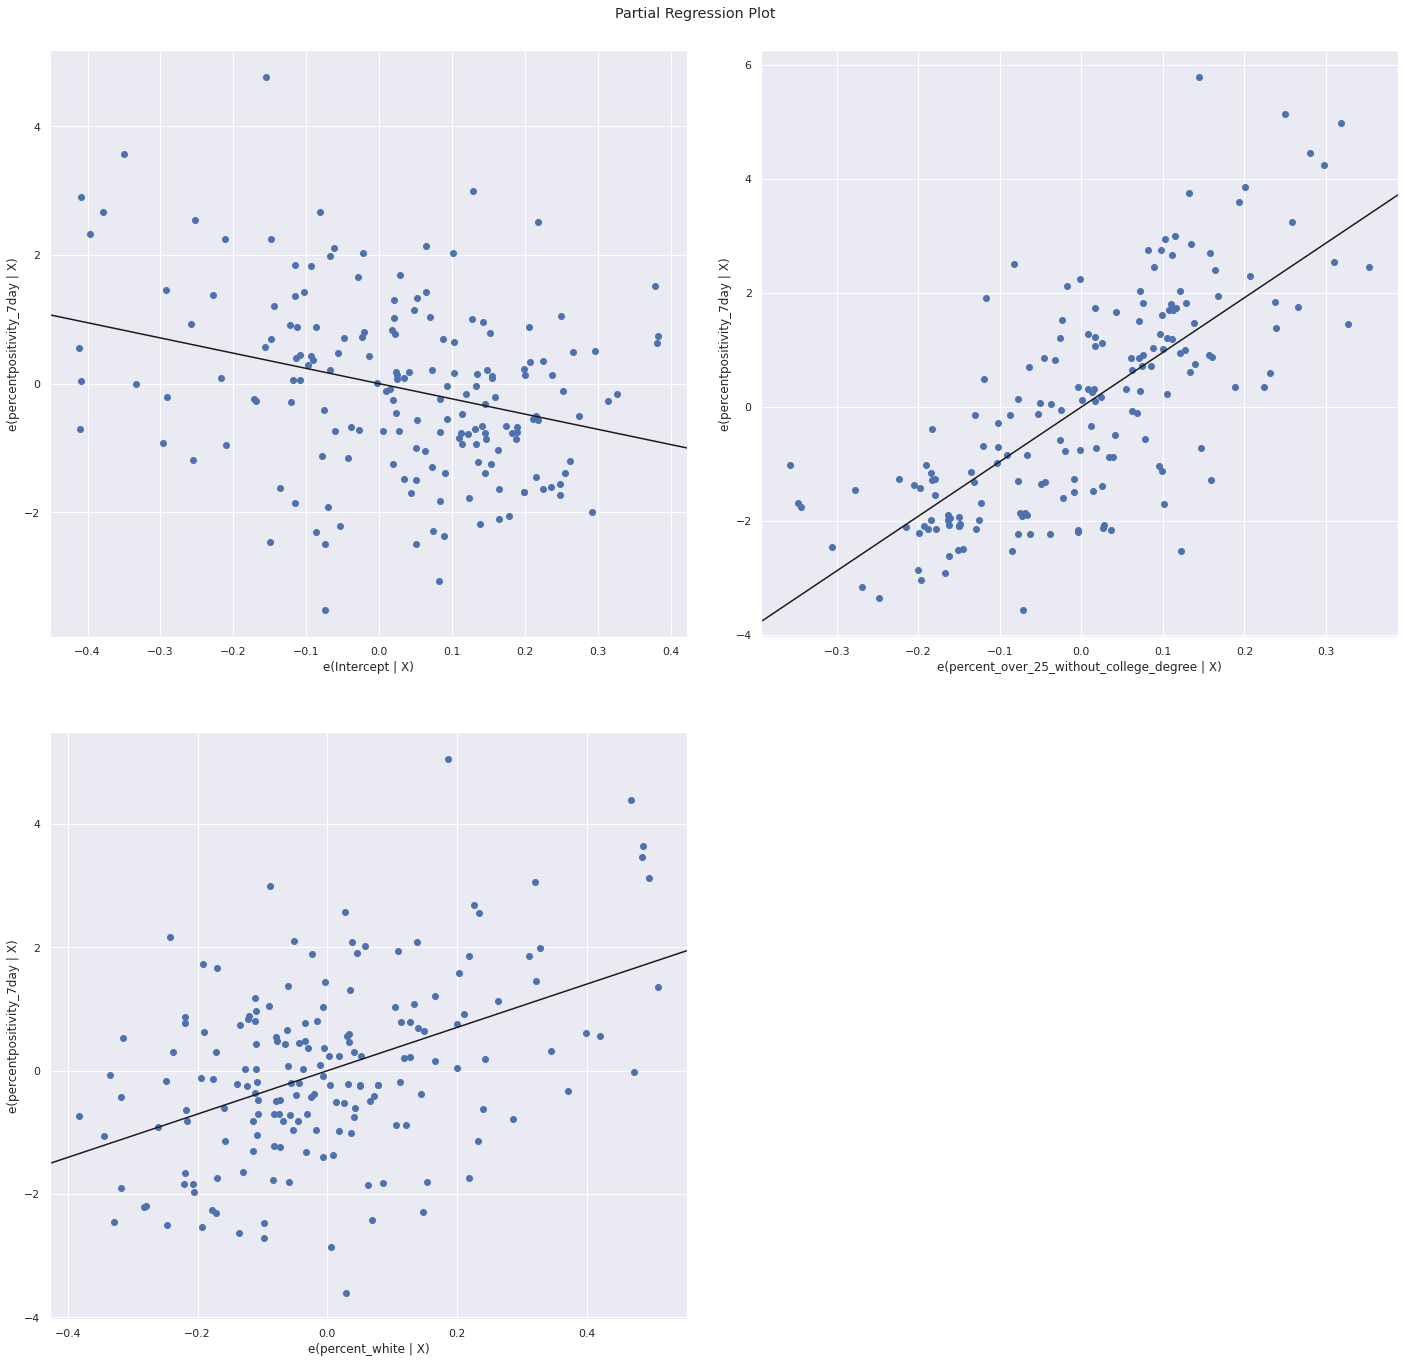

In [139]:
fig = sm.graphics.plot_partregress_grid(lm_edu_race)
fig.set_size_inches(20, 20)

In [163]:
lm = sm.OLS.from_formula("percentpositivity_7day ~ percent_over_25_without_college_degree + biden_margin + median_age + median_income + avg_num_people_per_household + percent_white", covid_vs_elections).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     percentpositivity_7day   R-squared:                       0.698
Model:                                OLS   Adj. R-squared:                  0.687
Method:                     Least Squares   F-statistic:                     65.03
Date:                    Sun, 06 Dec 2020   Prob (F-statistic):           2.23e-41
Time:                            18:53:57   Log-Likelihood:                -262.40
No. Observations:                     176   AIC:                             538.8
Df Residuals:                         169   BIC:                             561.0
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  4.2057      1.718      2.448      0.015       0.814       7.597
percent_over_25_without_college_degree     3.0964      1.334      2.320      0.022       0.462       5.731
biden_margin                              -3.1234      0.466     -6.696      0.000      -4.044      -2.203
median_age                                -0.0435      0.022     -1.969      0.051      -0.087       0.000
median_income                          -1.855e-06   5.02e-06     -0.370      0.712   -1.18e-05    8.05e-06
avg_num_people_per_household               0.8342      0.331      2.518      0.013       0.180       1.488
percent_white                             -0.8108      0.787     -1.030      0.304      -2.364       0.743
==============================================================================
Omnibus:                        2.738   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.317
Skew:                          -0.211   Prob(JB):                        0.314
Kurtosis:                       3.371   Cond. No.                     1.97e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

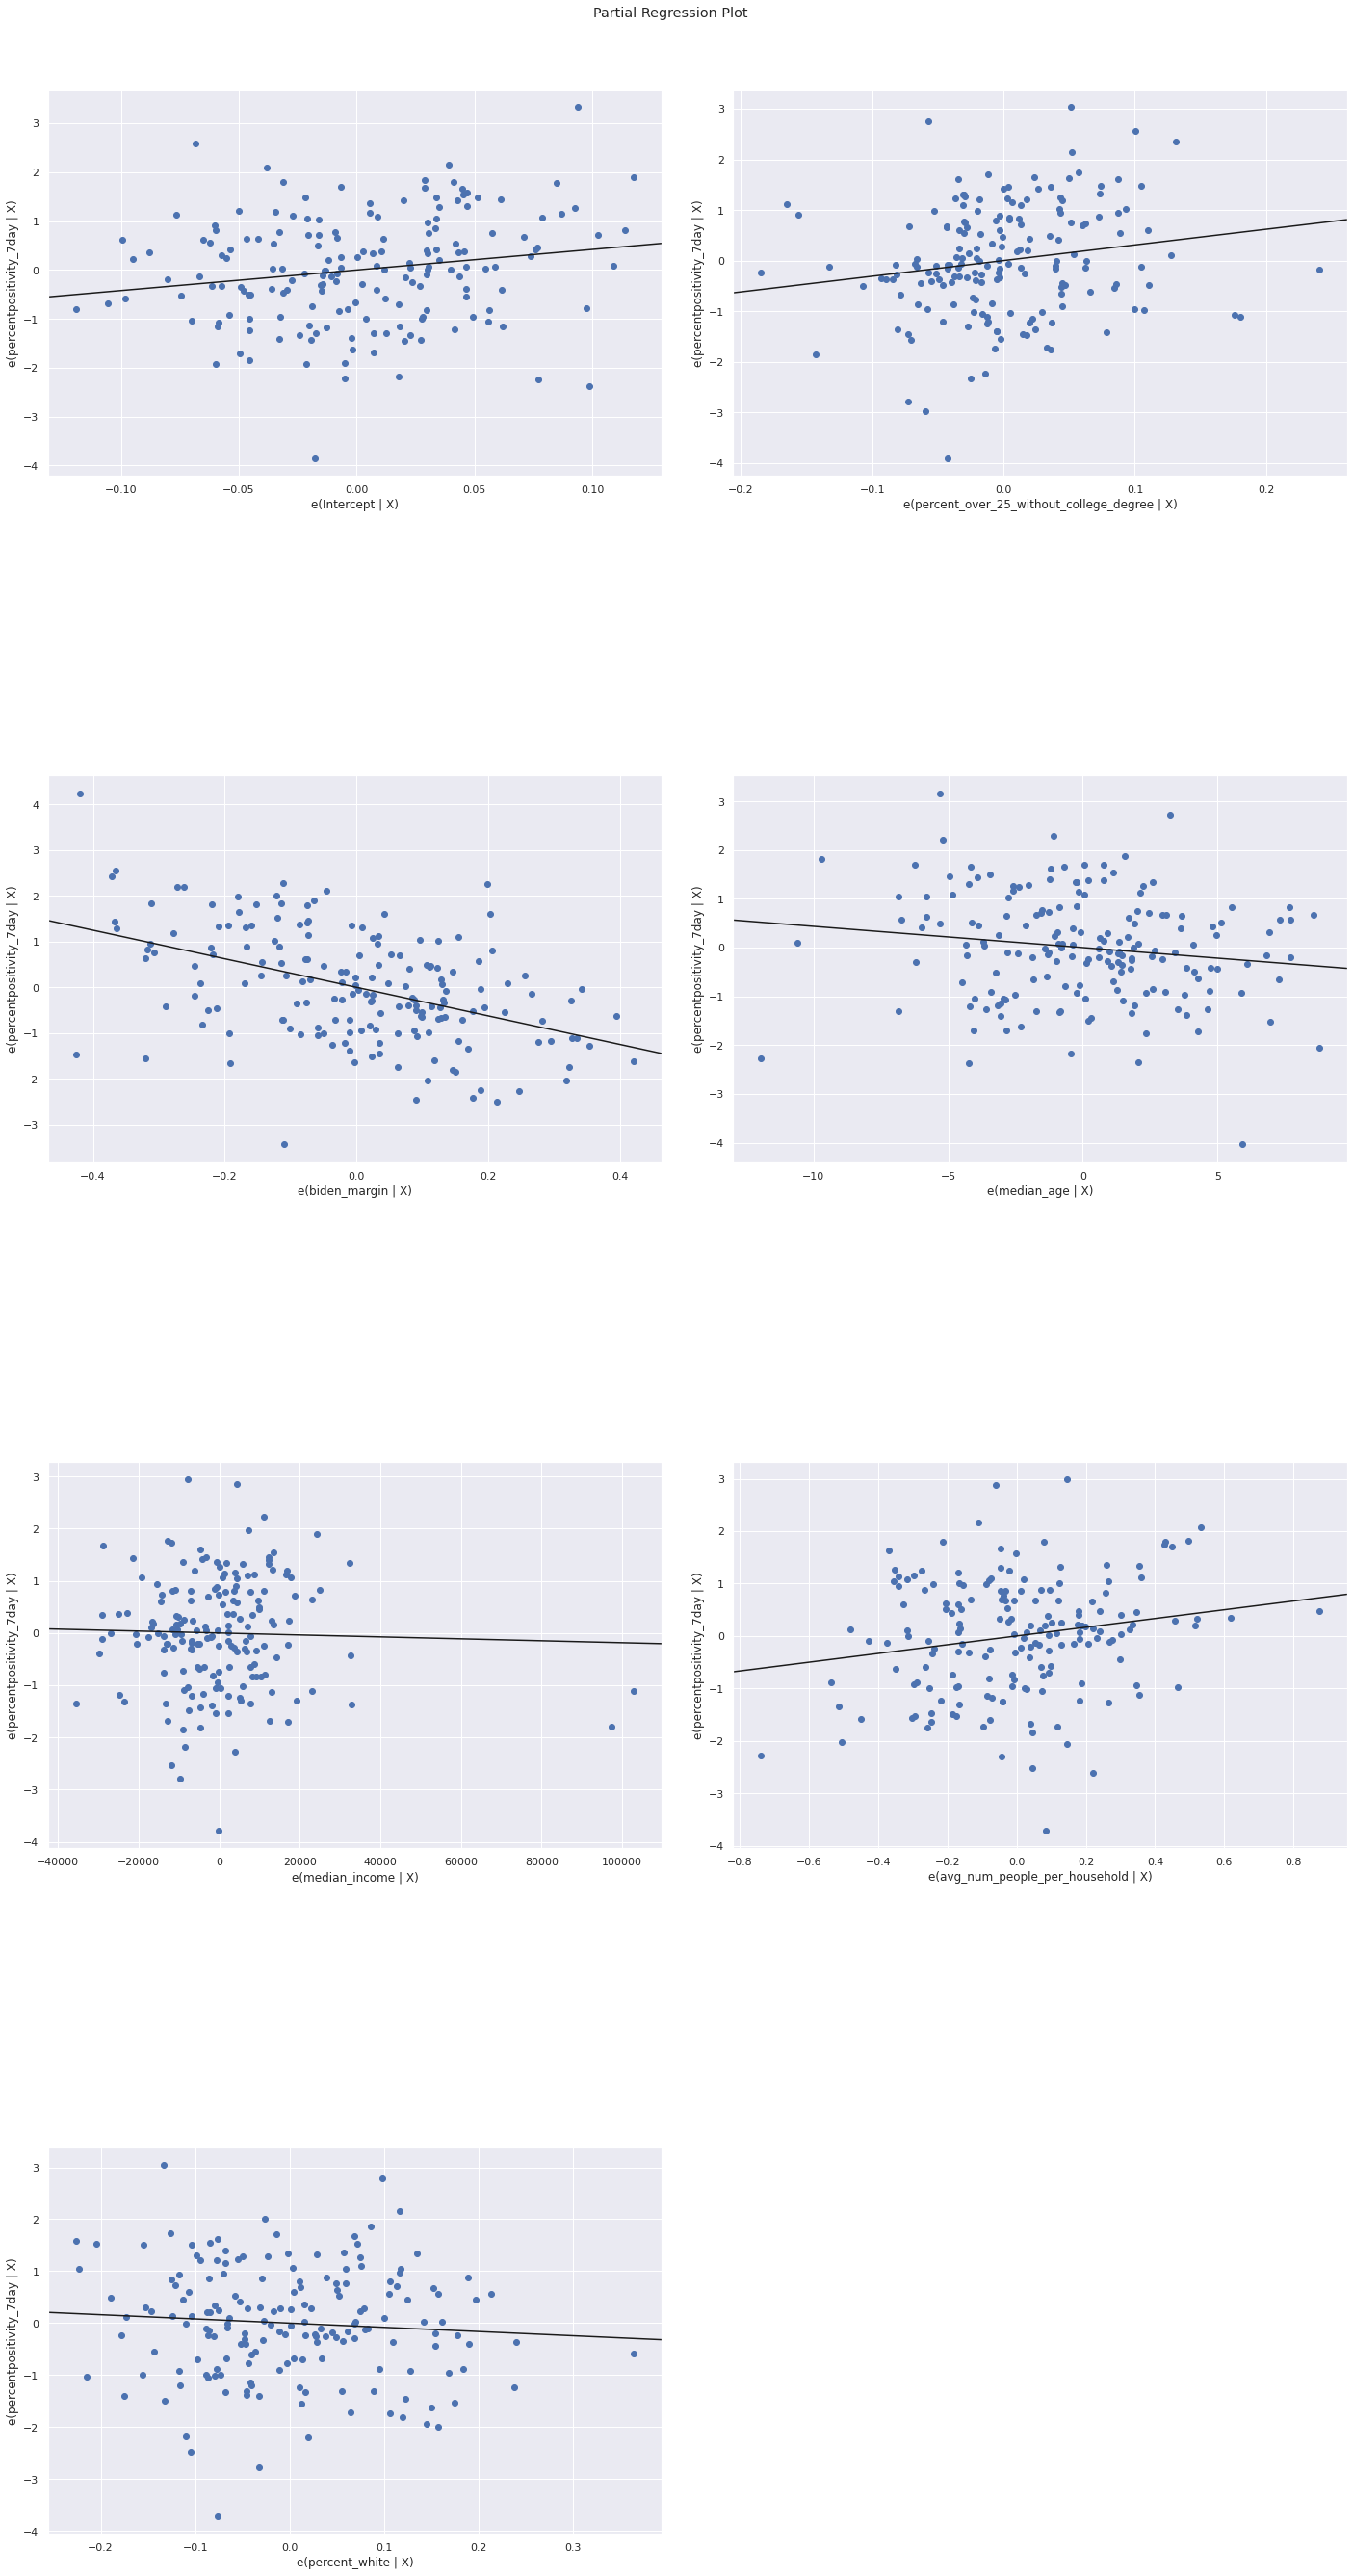

In [141]:
fig = sm.graphics.plot_partregress_grid(lm)
fig.set_size_inches(20, 40)

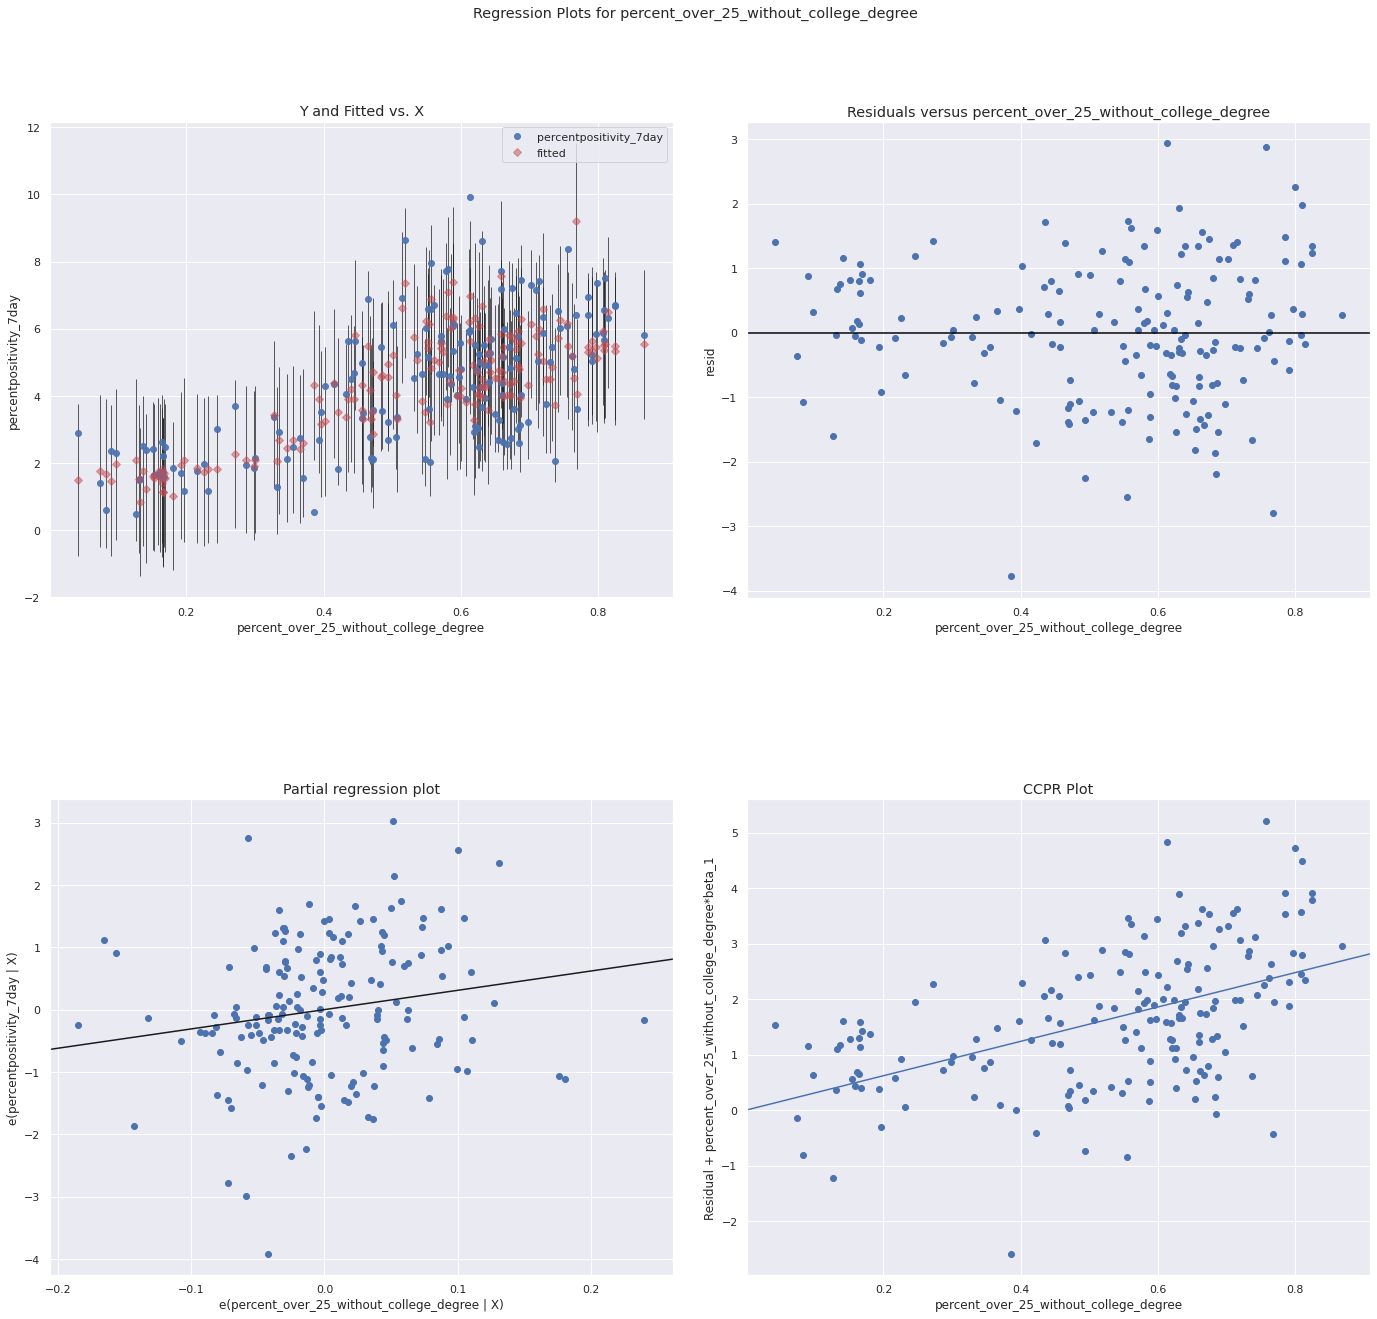

In [143]:
fig = sm.graphics.plot_regress_exog(lm, "percent_over_25_without_college_degree")
fig.set_size_inches(20, 20)

In [110]:
lm_biden_margin = sm.OLS.from_formula("biden_margin ~ median_income + median_age + percent_over_25_without_college_degree + avg_num_people_per_household + percent_white", covid_vs_elections).fit()
lm_biden_margin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           biden_margin   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     95.81
Date:                Sun, 06 Dec 2020   Prob (F-statistic):           1.35e-47
Time:                        18:28:54   Log-Likelihood:                 54.816
No. Observations:                 176   AIC:                            -97.63
Df Residuals:                     170   BIC:                            -78.61
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  2.9988      0.164     18.286      0.000       2.675       3.323
median_income                           1.709e-06   8.14e-07      2.098      0.037    1.01e-07    3.32e-06
median_age                                -0.0239      0.003     -7.647      0.000      -0.030      -0.018
percent_over_25_without_college_degree    -0.7287      0.212     -3.434      0.001      -1.148      -0.310
avg_num_people_per_household              -0.2551      0.051     -5.017      0.000      -0.356      -0.155
percent_white                             -1.3683      0.076    -18.085      0.000      -1.518      -1.219
==============================================================================
Omnibus:                        1.445   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.485   Jarque-Bera (JB):                1.466
Skew:                          -0.148   Prob(JB):                        0.480
Kurtosis:                       2.665   Cond. No.                     1.37e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

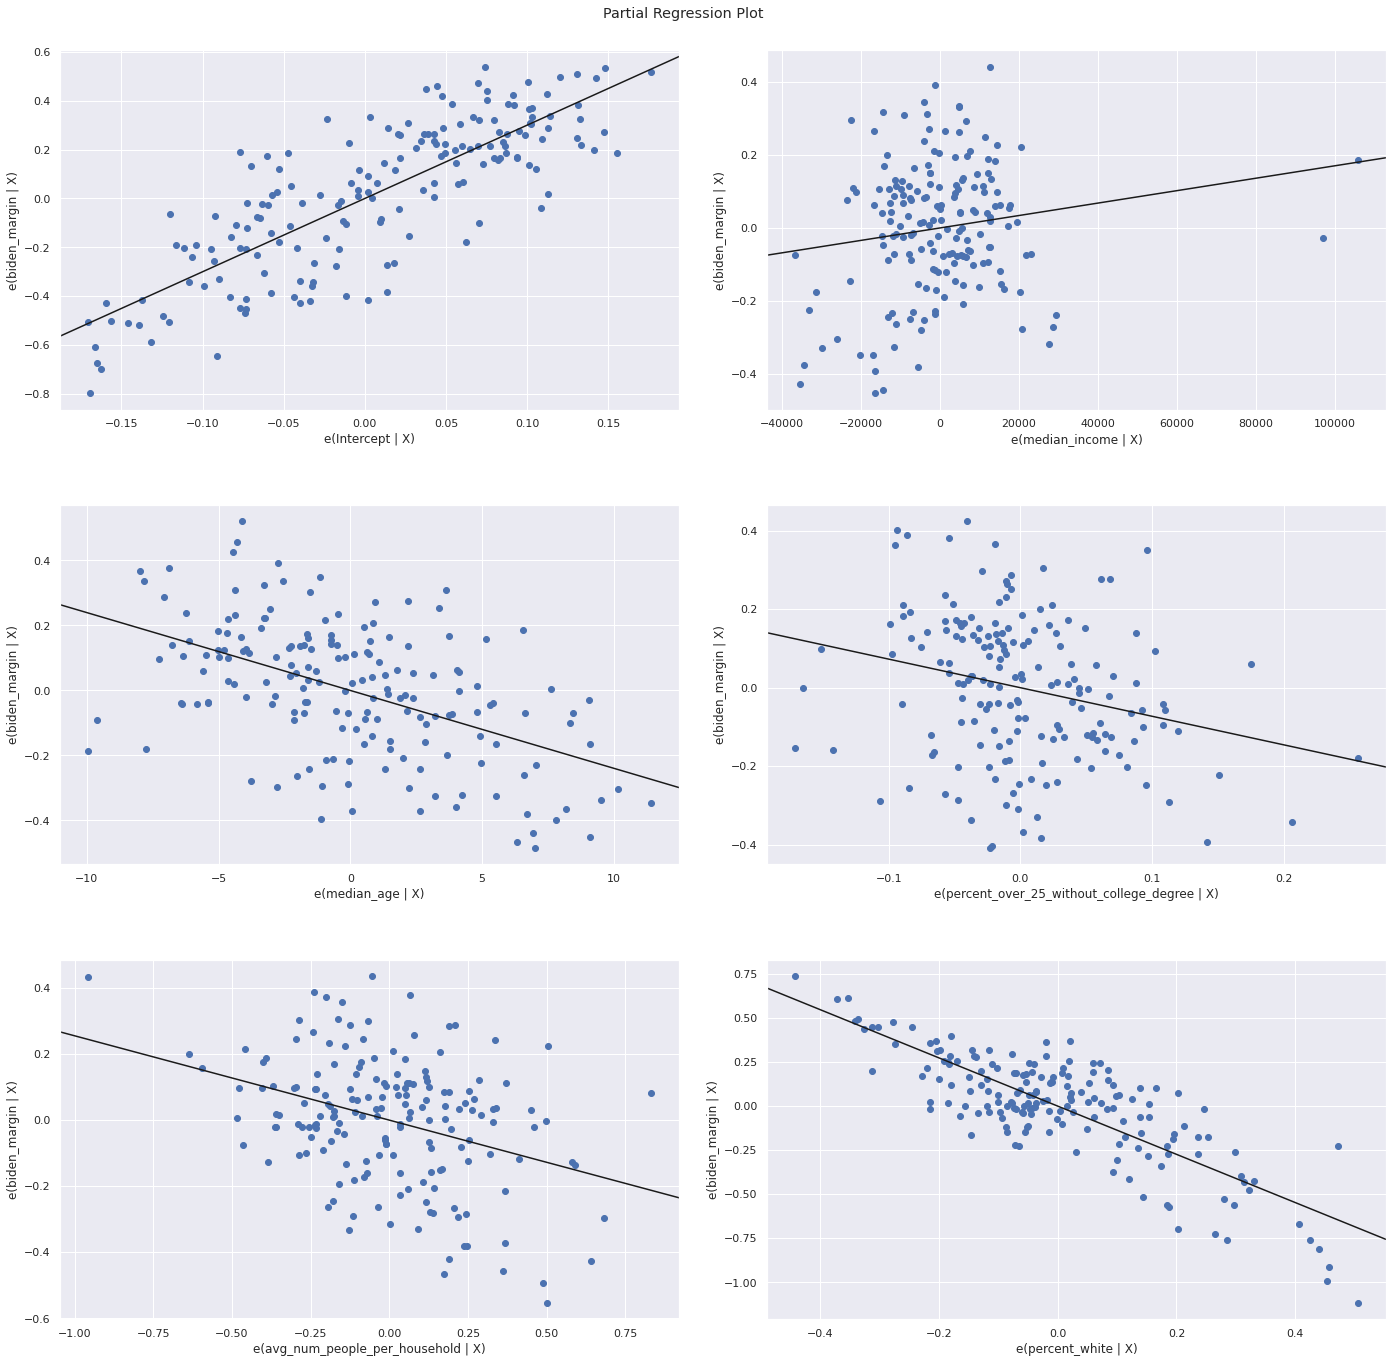

In [111]:
fig = sm.graphics.plot_partregress_grid(lm_biden_margin)
fig.set_size_inches(20, 20)

In [246]:
case_rate = pd.read_csv("/content/drive/MyDrive/covid_election_data/caserate-by-modzcta.csv")
case_rate = case_rate.transpose()
case_rate["modzcta"] = case_rate.index.map(lambda s: int(s[-5:]) if s[-1].isdigit() else s)
case_rate.set_index("modzcta", inplace=True)
covid_vs_elections["case_rate"] = case_rate[16].drop("week_ending").astype(float)

In [247]:
percent_positive = pd.read_csv("/content/drive/MyDrive/covid_election_data/percentpositive-by-modzcta.csv")
percent_positive = percent_positive.transpose()
percent_positive["modzcta"] = percent_positive.index.map(lambda s: int(s[-5:]) if s[-1].isdigit() else s)
percent_positive.set_index("modzcta", inplace=True)
covid_vs_elections["percent_positive"] = percent_positive[16].drop("week_ending").astype(float)

In [248]:
test_rate = pd.read_csv("/content/drive/MyDrive/covid_election_data/testrate-by-modzcta.csv")
test_rate = test_rate.transpose()
test_rate["modzcta"] = test_rate.index.map(lambda s: int(s[-5:]) if s[-1].isdigit() else s)
test_rate.set_index("modzcta", inplace=True)
covid_vs_elections["test_rate"] = test_rate[16].drop("week_ending").astype(float)

In [249]:
lm = sm.OLS.from_formula("percentpositivity_7day ~ test_rate + percent_over_25_without_college_degree + biden_margin + median_age + median_income + avg_num_people_per_household + percent_white", covid_vs_elections).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     percentpositivity_7day   R-squared:                       0.699
Model:                                OLS   Adj. R-squared:                  0.686
Method:                     Least Squares   F-statistic:                     55.64
Date:                    Sun, 06 Dec 2020   Prob (F-statistic):           1.48e-40
Time:                            19:21:04   Log-Likelihood:                -262.15
No. Observations:                     176   AIC:                             540.3
Df Residuals:                         168   BIC:                             565.7
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  4.0984      1.728      2.372      0.019       0.688       7.509
test_rate                               7.424e-05      0.000      0.697      0.487      -0.000       0.000
percent_over_25_without_college_degree     3.1507      1.339      2.353      0.020       0.508       5.794
biden_margin                              -3.2473      0.500     -6.497      0.000      -4.234      -2.261
median_age                                -0.0453      0.022     -2.035      0.043      -0.089      -0.001
median_income                          -2.135e-06   5.04e-06     -0.423      0.672   -1.21e-05    7.82e-06
avg_num_people_per_household               0.8514      0.333      2.558      0.011       0.194       1.508
percent_white                             -1.0406      0.854     -1.218      0.225      -2.727       0.646
==============================================================================
Omnibus:                        2.303   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.316   Jarque-Bera (JB):                1.874
Skew:                          -0.199   Prob(JB):                        0.392
Kurtosis:                       3.313   Cond. No.                     1.97e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

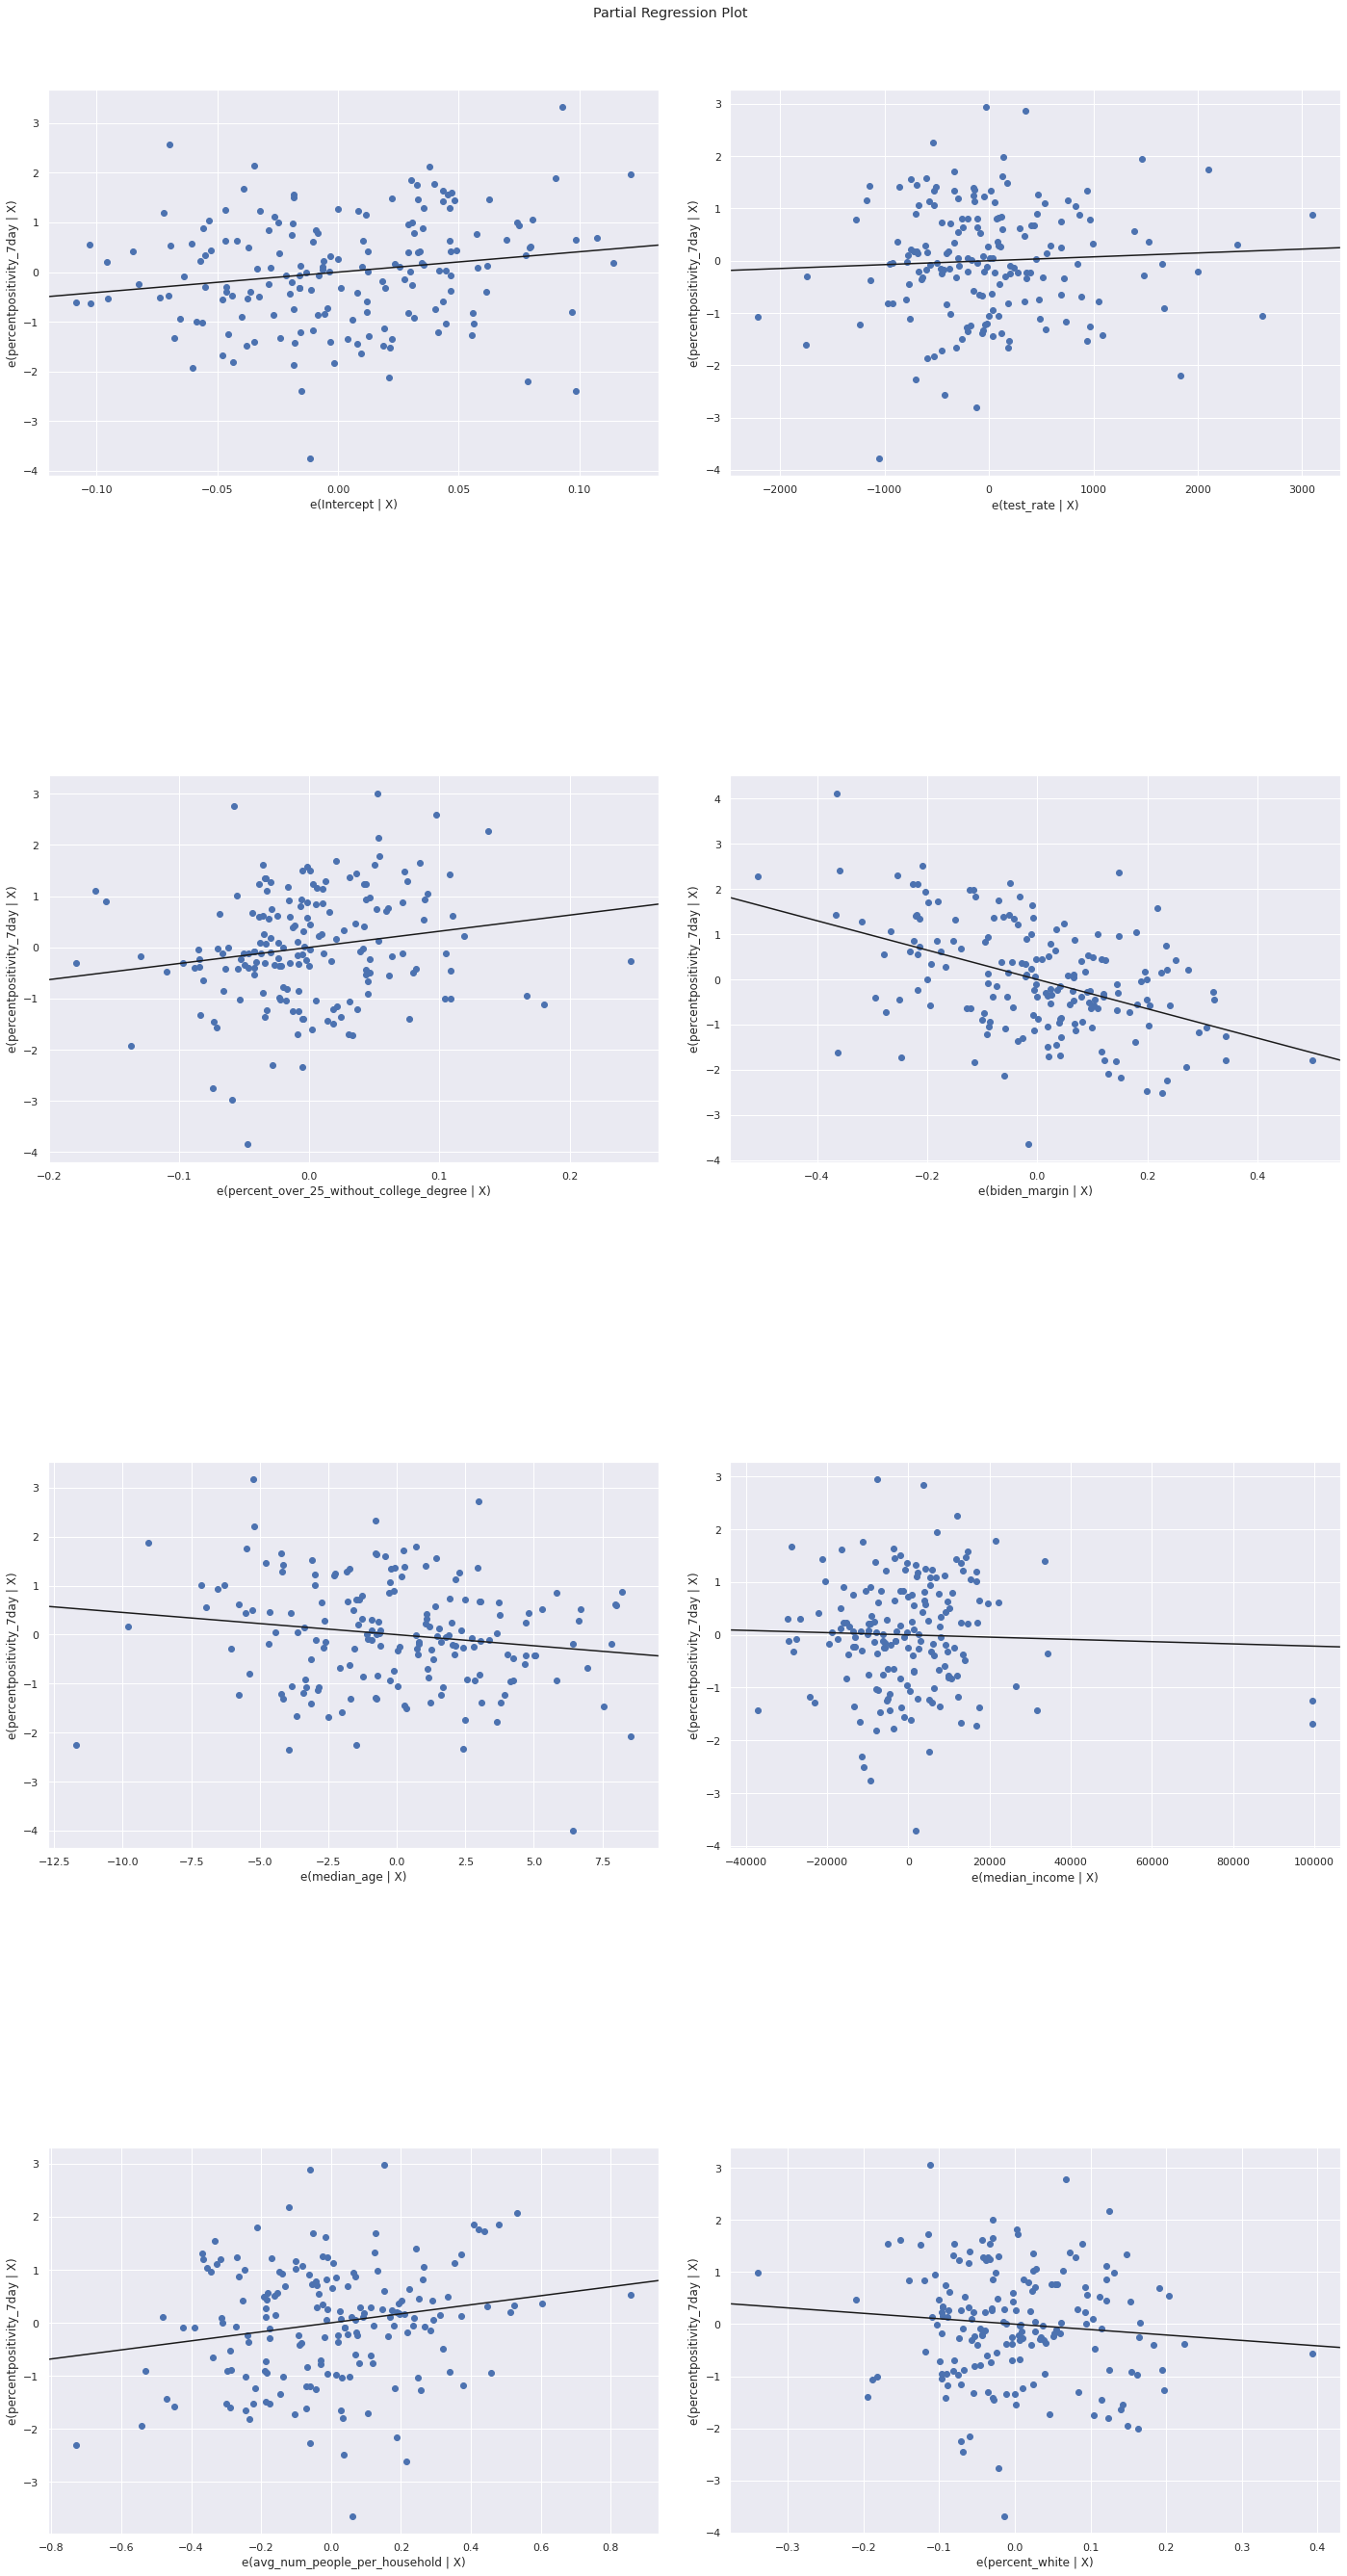

In [250]:
fig = sm.graphics.plot_partregress_grid(lm)
fig.set_size_inches(20, 40)

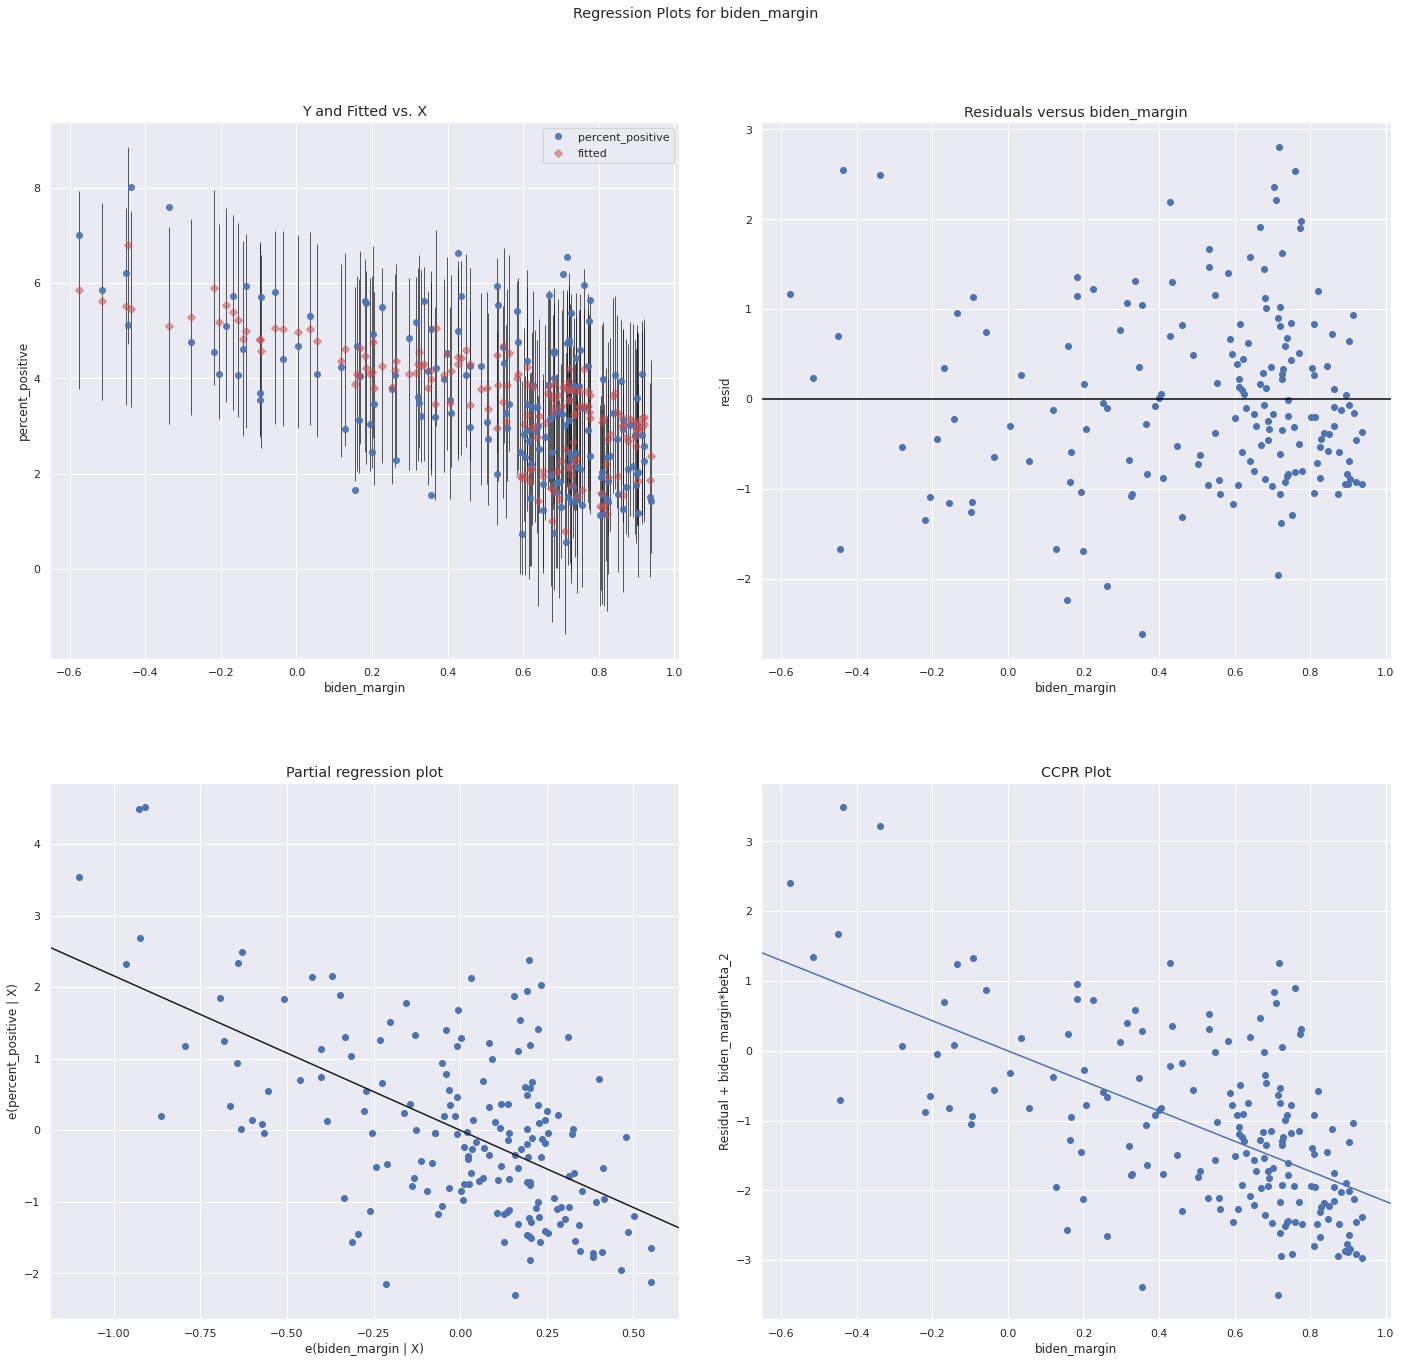

In [ ]:
fig = sm.graphics.plot_regress_exog(lm2, "biden_margin")
fig.set_size_inches(20, 20)

In [ ]:
lm_case_rate = sm.OLS.from_formula("case_rate ~ percent_positive + biden_margin + median_income + avg_num_people_per_household", covid_vs_elections).fit()
lm_case_rate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              case_rate   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     75.24
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.11e-36
Time:                        22:31:28   Log-Likelihood:                -868.41
No. Observations:                 176   AIC:                             1747.
Df Residuals:                     171   BIC:                             1763.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       30.6244     20.910      1.465      0.145     -10.650      71.898
percent_positive                37.0088      2.548     14.526      0.000      31.980      42.038
biden_margin                    16.2516      9.466      1.717      0.088      -2.434      34.937
median_income                    0.0006   8.31e-05      7.710      0.000       0.000       0.001
avg_num_people_per_household   -30.6502      5.933     -5.166      0.000     -42.361     -18.939
==============================================================================
Omnibus:                       50.799   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.996
Skew:                           1.172   Prob(JB):                     5.39e-32
Kurtosis:                       6.761   Cond. No.                     6.98e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

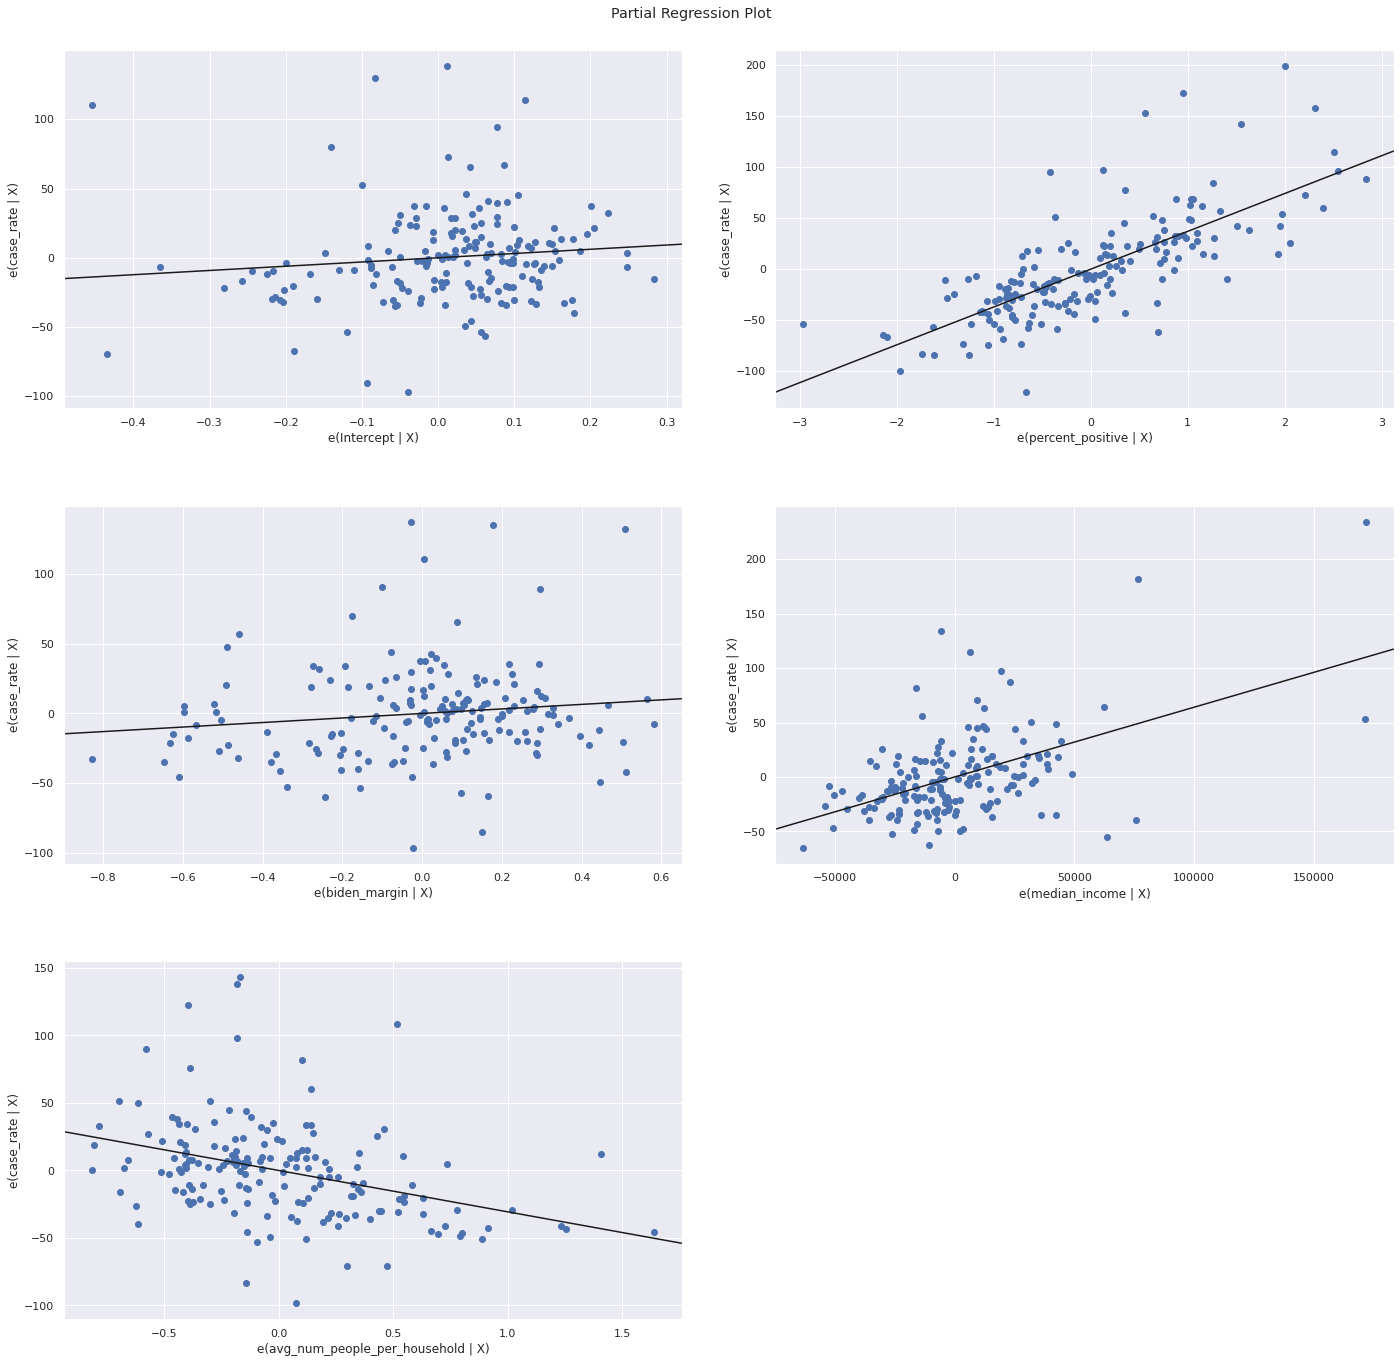

In [ ]:
fig = sm.graphics.plot_partregress_grid(lm_case_rate)
fig.set_size_inches(20, 20)

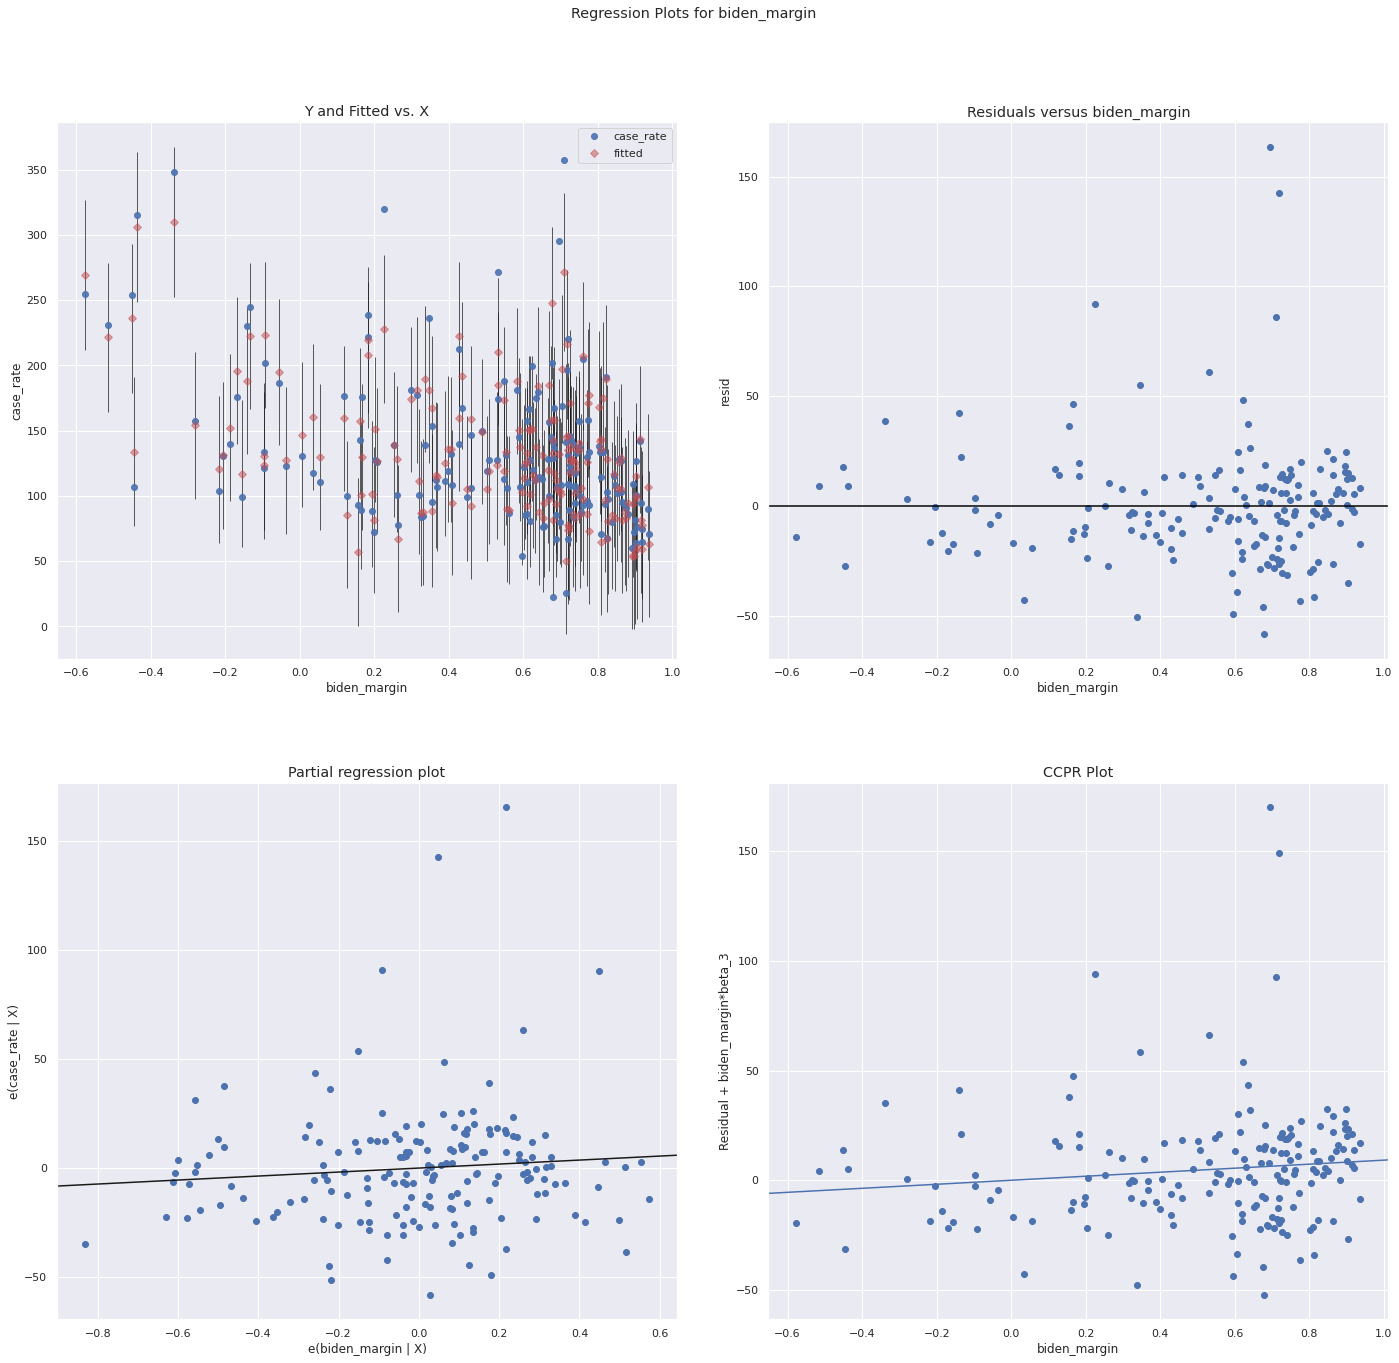

In [ ]:
fig = sm.graphics.plot_regress_exog(lm_case_rate, "biden_margin")
fig.set_size_inches(20, 20)